# Sales Prediction & Forecasting for Brazilian E-Commerce Public Dataset by Olist

In [1]:
# Import all required libraries
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor

## Data Pre-Processing

As the dataset is separated into various blocks, dataset merging is essential to create a new dataset which is suitable for this job. Four datasets shall be involved in this progress, including ‘order’, ‘item’, ‘product’, and 'product category name translation'. Join shall be done on ‘order’ and ‘item’ datasets by merging ‘order_id’ to obtain the information of the items purchased in each order. Another join will be done on the new joint dataset with the ‘product’ dataset by merging ‘product_id’ so that all items are attached with the product name. Since the product category name is in Portugese, the translation table is merged to gain the product category name in English.

In [2]:
# Import all related dataset for merging
df1 = pd.read_csv('olist_orders_dataset.csv')
df2 = pd.read_csv('olist_order_items_dataset.csv')
df3 = pd.read_csv('olist_products_dataset.csv')
df4 = pd.read_csv('product_category_name_translation.csv')

# Merging dataset
df5 = df1.merge(df2, on = 'order_id').merge(df3, on = 'product_id').merge(df4, on = 'product_category_name')
df5.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,87285b34884572647811a353c7ac498a,...,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
4,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,1,be021417a6acb56b9b50d3fd2714baa8,...,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares


The transactions with “delivered” status only will be involved in the analysis. The merged dataset is filtered to keep only transactions with ‘delivered’ status. Two attributes shall be focused on, which are “order_purchase_timestamp” in the ‘order’ dataset and the value of products such as “health_beauty” that belongs to the “product_category” attribute in the ‘product’ dataset.

In [3]:
# Extract required attributes from the merged dataset
df5 = df5.loc[df5['order_status'] == 'delivered']
df6 = df5[['order_purchase_timestamp','product_category_name_english']]
df6.head()

,order_purchase_timestamp,product_category_name_english
0,2017-10-02 10:56:33,housewares
1,2017-08-15 18:29:31,housewares
2,2017-08-02 18:24:47,housewares
3,2017-10-23 23:26:46,housewares
4,2017-11-24 21:27:48,housewares


Since we would like to focus only on dates, the “order_purchase_timestamp” attribute is converted to date-only format using the to_datetime function. A new column ‘value’ shall be assigned to label each transaction as 1 sale.

In [4]:
# Filter warnings
warnings.filterwarnings("ignore")

# Create new column with only date
df6['order_date'] = pd.to_datetime(df6['order_purchase_timestamp']).dt.date
df6['order_date'] = pd.to_datetime(df6['order_date'])

# Count each transaction as 1 sale
df6["value"] = 1
df6.head()

,order_purchase_timestamp,product_category_name_english,order_date,value
0,2017-10-02 10:56:33,housewares,2017-10-02,1
1,2017-08-15 18:29:31,housewares,2017-08-15,1
2,2017-08-02 18:24:47,housewares,2017-08-02,1
3,2017-10-23 23:26:46,housewares,2017-10-23,1
4,2017-11-24 21:27:48,housewares,2017-11-24,1


A pivot table shall be built using the Pandas library by aggregating the sales values of products by date.

In [5]:
# Turn dataset into pivot table
table = df6.pivot_table(index = ['order_date'], columns = 'product_category_name_english', values = 'value', aggfunc = 'sum')
data = table.fillna(0)
data.head()

product_category_name_english,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_date,,,,,,,,,,,,,,,,,,,,,
2016-09-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0
2016-10-04,0.0,4.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0
2016-10-05,0.0,4.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,6.0,0.0
2016-10-06,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0,2.0


We shall demonstrate the application of time series by focusing on toy sales in this project. It is found that the dataset has only a few entries for the year 2016 and there are empty dates across the years 2017 and 2018. A little pre-processing is needed for the time-series data to be validated for prediction. 

Since there is insufficient data for year 2016, the data for year 2016 is dropped out from the table. As for the empty dates across year 2017 and 2018, it is filled with sales value of zero since there is no sales record across all empty dates.

In [6]:
# Extract toys sales from the data
df7 = df6.loc[df6['product_category_name_english'] == 'toys']
df7 = df7[['order_date','product_category_name_english','value']]
df7['order_date'] = pd.to_datetime(df7['order_date'])

# Drop 2016 data and move order date as index
df8 = df7.groupby('order_date').sum().reset_index()
df8 = df8.drop([0,1,2,3,4,5,6])
df8 = df8.set_index('order_date')
df8.columns = ['toys_sales']

# Fill in empty dates
idx = pd.date_range('01-05-2017','08-29-2018') 
df8 = df8.reindex(idx, fill_value = 0)

df8.head()

,toys_sales
2017-01-05,2
2017-01-06,1
2017-01-07,0
2017-01-08,0
2017-01-09,0


Once the dataset is built, it is plotted to determine Time Series Components and determine the trend of the dataset as Seasonal, Cyclical, or Irregular.

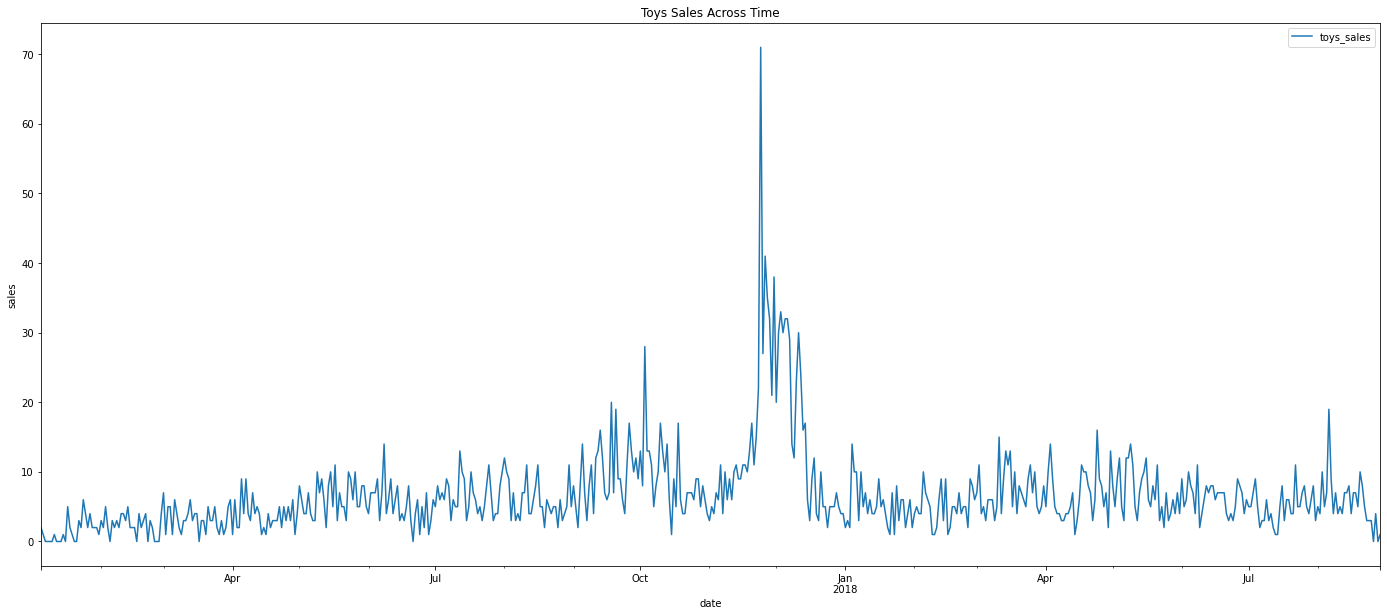

In [7]:
# Trend plot for toys sales
df8.plot(figsize=(24,10))
plt.title('Toys Sales Across Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

By plotting the data as in the figure above, it is observed that the data is distributed evenly with an upward trend in the year 2017. However, the trend changes downward after it reaches its peak at the end of the year 2017. The data trend becomes flat in the year 2018. The dataset has an irregular component.

## ADF Test

Checking on the stationarity of the data is required before proceeding to time series modelling. The ADF test is carried out to determine whether the dataset is stationary.

In [8]:
# Check dataset stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key,value))
        
check_stationarity(df8.toys_sales)

The test statistic: -3.283362
p-value: 0.015639
Critical Values:
1%: -3.441
5%: -2.866
10%: -2.569


It is shown the p-value for the dataset is below 0.05, rejecting the null hypothesis with strong confidence. Therefore, the data is stationary and no differencing is required.

# ARIMA

The first model parameters are determining the value of p " the number of autoregressive”, d "degree of differencing”, q "the number of moving average", that represents the (p,d,q) in order.

The d value can be determined by testing the stationary of the time series; the p and q values are determined by observing the ACF plot "Autocorrelation function "and PACF plot "autocorrelations" sequentially.

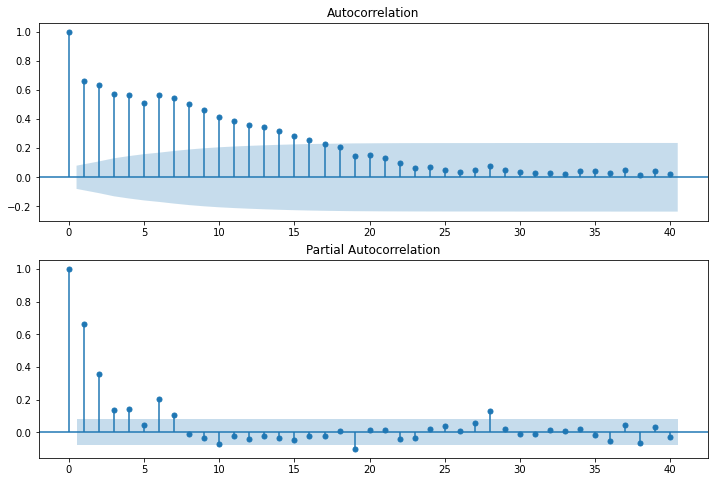

In [9]:
# ACF and PACF plot
def lagplot(column):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(column, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(column, lags=40, ax=ax2)

lagplot(df8.toys_sales)

• By observing the ACF plot, it tails off gradually since Lag 1, hence MA model with a value of 1 is possible.
<br>
• By observing the PACF plot, the significant lag cuts off after Lag 1, hence an AR model with Lag 1 is essential.

Through experimentation, it is known the value for p, d, and q shall be 1, 0, and 1 respectively. These values shall fit into the ARIMA model and be evaluated using the metrics, MAE and RMSE.

In [10]:
# Filter warnings
warnings.filterwarnings("ignore")

# ARIMA modelling
mod = ARIMA(df8.toys_sales, order = (1,0,1))
results = mod.fit()
print(results.summary())

# Check on forecast
n = 100
forecast = results.forecast(steps = n)
df_forecast = pd.DataFrame({'forecast':forecast}, index = pd.date_range(data.index[-1], periods = n, freq='D'))
print(df_forecast)

                               SARIMAX Results                                
Dep. Variable:             toys_sales   No. Observations:                  602
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1703.735
Date:                Thu, 15 Sep 2022   AIC                           3415.471
Time:                        20:30:40   BIC                           3433.072
Sample:                    01-05-2017   HQIC                          3422.322
                         - 08-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3208      1.892      3.341      0.001       2.613      10.029
ar.L1          0.9563      0.010     97.349      0.000       0.937       0.976
ma.L1         -0.6413      0.029    -22.220      0.0

In [11]:
# MSE & RMSE for ARIMA 1
ARIMA_mse = mse(df8.toys_sales, results.predict())
print('The MSE value for first ARIMA model:', ARIMA_mse)

ARIMA_rmse = mse(df8.toys_sales, results.predict(), squared = False)
print("The RMSE value for first ARIMA model:", ARIMA_rmse)

The MSE value for first ARIMA model: 16.80574959559327
The RMSE value for first ARIMA model: 4.099481625229374


# Auto ARIMA

Auto ARIMA is used for the second ARIMA model to find out the best combination of values p, d, and q by considering the AIC and BIC values generated with each combination of parameters.

In [12]:
# Search for optimum parameters using auto ARIMA function
auto_arima_fit = pm.auto_arima(df8.toys_sales, start_p = 1, start_q = 1,
                              max_p = 6, max_q = 6, m = 12,
                              test = 'adf',
                              d = None,
                              seasonal = False,
                              trace = True,
                              error_action='ignore',
                              surpress_warnings=True,
                              stepwise= True)
auto_arima_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3420.776, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3633.047, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3485.890, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3419.302, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3631.047, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3420.864, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3420.921, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3417.303, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3418.777, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3418.865, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3483.890, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3418.922, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.474 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  602
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1706.651
Date:                Thu, 15 Sep 2022   AIC                           3417.303
Time:                        20:30:41   BIC                           3426.100
Sample:                             0   HQIC                          3420.727
                                - 602                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6780      0.022    -30.961      0.000      -0.721      -0.635
sigma2        17.1242      0.254     67.528      0.000      16.627      17.621
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             69206.51
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             3.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

By observing the result, it is suggested that the best combination for (p, d, q) should be (0, 1, 1). After fitting the suggested values into the ARIMA model, the model is evaluated with MSE and RMSE.

In [13]:
# ARIMA modelling
mod1 = ARIMA(df8.toys_sales, order = (0,1,1))
results1 = mod1.fit()
print(results1.summary())

# Check on forecast
n = 100
forecast1 = results1.forecast(steps = n)
df_forecast1 = pd.DataFrame({'forecast':forecast1}, index = pd.date_range(data.index[-1], periods = n, freq='D'))
print(df_forecast1)

                               SARIMAX Results                                
Dep. Variable:             toys_sales   No. Observations:                  602
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1706.651
Date:                Thu, 15 Sep 2022   AIC                           3417.303
Time:                        20:30:42   BIC                           3426.100
Sample:                    01-05-2017   HQIC                          3420.727
                         - 08-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6780      0.022    -30.961      0.000      -0.721      -0.635
sigma2        17.1242      0.254     67.528      0.000      16.627      17.621
Ljung-Box (L1) (Q):                   0.23   Jarque-

In [14]:
# MSE & RMSE for ARIMA 2
ARIMA2_mse = mse(df8.toys_sales, results1.predict())
print('The MSE value for second ARIMA model:', ARIMA2_mse)

ARIMA2_rmse = mse(df8.toys_sales, results1.predict(), squared = False)
print("The RMSE value for second ARIMA model:", ARIMA2_rmse)

The MSE value for second ARIMA model: 17.103095815779117
The RMSE value for second ARIMA model: 4.135588932156956


# Machine Learning

Another two time series model shall be built based on a machine learning algorithm, XGBoost. Distinct learning rate will be implemented in both models and tested with MAE, MSE and RMSE.

Before proceeding to the modelling, splitting the dataset into a training and testing set is required. The figure below shows the code and shape of the training and test set. Since there are 602 observations, the data is split into the thumb rule used by practitioners, which is 80% of training data (480 observations) and 20% of testing data (121 observations)

The first model is set with a learning rate of 0.01 while the second model is set with a learning rate of 0.05.

In [15]:
# Assign features and labels
features = ['toys_sales']
label = 'toys_sales'

# Splitting into train and test set
test_df = df8[481:]
train_df = df8[0:480]
x_train, y_train = train_df[features], train_df[label]
x_test, y_test = test_df[features], test_df[label]

# Check on train and test set shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(480, 1)
(480,)
(121, 1)
(121,)


### XGBoost with learning_rate = 0.01

In [16]:
# XGBoost with learning_rate = 0.01
reg1 = XGBRegressor(n_estimators = 100, learning_rate = 0.01)
reg1.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        eval_metric = 'mae')

[0]	validation_0-mae:6.28003	validation_1-mae:5.46955
[1]	validation_0-mae:6.21899	validation_1-mae:5.41484
[2]	validation_0-mae:6.15869	validation_1-mae:5.36132
[3]	validation_0-mae:6.09897	validation_1-mae:5.30833
[4]	validation_0-mae:6.03983	validation_1-mae:5.25585
[5]	validation_0-mae:5.98132	validation_1-mae:5.20375
[6]	validation_0-mae:5.92332	validation_1-mae:5.15230
[7]	validation_0-mae:5.86594	validation_1-mae:5.10122
[8]	validation_0-mae:5.80906	validation_1-mae:5.05078
[9]	validation_0-mae:5.75279	validation_1-mae:5.00069
[10]	validation_0-mae:5.69722	validation_1-mae:4.95137
[11]	validation_0-mae:5.64203	validation_1-mae:4.90226
[12]	validation_0-mae:5.58753	validation_1-mae:4.85390
[13]	validation_0-mae:5.53345	validation_1-mae:4.80534
[14]	validation_0-mae:5.47985	validation_1-mae:4.75766
[15]	validation_0-mae:5.42692	validation_1-mae:4.71071
[16]	validation_0-mae:5.37439	validation_1-mae:4.66357
[17]	validation_0-mae:5.32248	validation_1-mae:4.61754
[18]	validation_0-ma

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [17]:
# MAE, MSE, RMSE for XGBoost 1
XGBoost1_mae = mae(y_test, reg1.predict(x_test))
print('The MAE value for first XGBoost model:', XGBoost1_mae)

XGBoost1_mse = mse(y_test, reg1.predict(x_test))
print('The MSE value for first XGBoost model:', XGBoost1_mse)

XGBoost1_rmse = mse(y_test, reg1.predict(x_test), squared = False)
print("The RMSE value for first XGBoost model:", XGBoost1_rmse)

The MAE value for first XGBoost model: 2.047901834830765
The MSE value for first XGBoost model: 5.423242033719065
The RMSE value for first XGBoost model: 2.3287855276343215


In [18]:
# Model prediction on full data
prediction1 = reg1.predict(df8)

# Merge prediction with original data
test1_df = df8.reset_index().drop('index', axis=1)
test1_df['prediction'] = pd.Series(prediction1)
test1_df = test1_df.set_index(pd.date_range(start='1/5/2017', end='8/29/2018', freq = 'D'))
test1_df.index = pd.to_datetime(test1_df.index)

test1_df

,toys_sales,prediction
2017-01-05,2,1.436912
2017-01-06,1,0.809439
2017-01-07,0,0.193006
2017-01-08,0,0.193006
2017-01-09,0,0.193006
...,...,...
2018-08-25,3,2.067314
2018-08-26,0,0.193006
2018-08-27,4,2.697846
2018-08-28,0,0.193006


### XGBoost with learning_rate = 0.05

In [19]:
# XGBoost with learning_rate = 0.05
reg2 = XGBRegressor(n_estimators = 100, learning_rate = 0.05)
reg2.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        eval_metric = 'mae')

[0]	validation_0-mae:6.03348	validation_1-mae:5.24856
[1]	validation_0-mae:5.74124	validation_1-mae:4.98842
[2]	validation_0-mae:5.46290	validation_1-mae:4.74178
[3]	validation_0-mae:5.19854	validation_1-mae:4.50456
[4]	validation_0-mae:4.94641	validation_1-mae:4.28246
[5]	validation_0-mae:4.70702	validation_1-mae:4.06953
[6]	validation_0-mae:4.47933	validation_1-mae:3.86384
[7]	validation_0-mae:4.26262	validation_1-mae:3.67244
[8]	validation_0-mae:4.05691	validation_1-mae:3.48594
[9]	validation_0-mae:3.86158	validation_1-mae:3.31060
[10]	validation_0-mae:3.67530	validation_1-mae:3.14850
[11]	validation_0-mae:3.49866	validation_1-mae:2.99448
[12]	validation_0-mae:3.33064	validation_1-mae:2.84920
[13]	validation_0-mae:3.17029	validation_1-mae:2.70747
[14]	validation_0-mae:3.01794	validation_1-mae:2.57616
[15]	validation_0-mae:2.87333	validation_1-mae:2.45120
[16]	validation_0-mae:2.73544	validation_1-mae:2.33347
[17]	validation_0-mae:2.60311	validation_1-mae:2.21758
[18]	validation_0-ma

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [20]:
# MAE, MSE, RMSE for XGBoost 2
XGBoost2_mae = mae(y_test, reg2.predict(x_test))
print('The MAE value for second XGBoost model:', XGBoost2_mae)

XGBoost2_mse = mse(y_test, reg2.predict(x_test))
print('The MSE value for second XGBoost model:', XGBoost2_mse)

XGBoost2_rmse = mse(y_test, reg2.predict(x_test), squared = False)
print("The RMSE value for second XGBoost model:", XGBoost2_rmse)

The MAE value for second XGBoost model: 0.03487660640404244
The MSE value for second XGBoost model: 0.0016084933851653787
The RMSE value for second XGBoost model: 0.040106026793555336


In [21]:
# Model prediction on full data
prediction2 = reg2.predict(df8)

# Merge prediction with original data
test2_df = df8.reset_index().drop('index', axis=1)
test2_df['predictions'] = pd.Series(prediction2)
test2_df = test2_df.set_index(pd.date_range(start='1/5/2017', end='8/29/2018', freq = 'D'))
test2_df.index = pd.to_datetime(test2_df.index)

test2_df

,toys_sales,predictions
2017-01-05,2,1.989629
2017-01-06,1,0.996438
2017-01-07,0,0.004340
2017-01-08,0,0.004340
2017-01-09,0,0.004340
...,...,...
2018-08-25,3,2.983654
2018-08-26,0,0.004340
2018-08-27,4,3.977443
2018-08-28,0,0.004340


## Convert Time Series Data into Supervised Learning Data

Before proceeding to walk-forward validation, We will define a new Python function named series_to_supervised() that takes a univariate or multivariate time series and frames it as a supervised learning dataset.

In [22]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [23]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [24]:
# transform the time series data into supervised learning
data1 = series_to_supervised(df8.toys_sales, n_in=6)
data1

array([[2., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [8., 5., 3., ..., 3., 0., 4.],
       [5., 3., 3., ..., 0., 4., 0.],
       [3., 3., 3., ..., 4., 0., 1.]])

## Walk-Forward Validation

In time series, it is not possible to use the normal cross validation methods as the normal cross validation will randomly pick set of data and train the model. The prediction should always come from the last rows of our data. Hence, the suitable validation method for time series is walk-forward validation.

### XGBoost with learning_rate = 0.01

In [25]:
# fit an xgboost model and make a one step forecasting
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate = 0.01)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [26]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mse(test[:, -1], predictions)
    return error, test[:, -1], predictions

>expected=3.0, predicted=7.0
>expected=5.0, predicted=4.4
>expected=2.0, predicted=4.2
>expected=7.0, predicted=4.3
>expected=3.0, predicted=3.7
>expected=4.0, predicted=3.7
>expected=6.0, predicted=3.2
>expected=4.0, predicted=3.5
>expected=7.0, predicted=2.5
>expected=4.0, predicted=4.7
>expected=9.0, predicted=3.1
>expected=5.0, predicted=4.8
>expected=6.0, predicted=4.7
>expected=10.0, predicted=3.6
>expected=8.0, predicted=4.3
>expected=7.0, predicted=4.1
>expected=4.0, predicted=4.3
>expected=11.0, predicted=3.7
>expected=2.0, predicted=5.7
>expected=4.0, predicted=4.8
>expected=6.0, predicted=3.2
>expected=8.0, predicted=4.4
>expected=7.0, predicted=4.3
>expected=8.0, predicted=4.5
>expected=8.0, predicted=4.1
>expected=6.0, predicted=4.2
>expected=7.0, predicted=4.1
>expected=7.0, predicted=4.9
>expected=7.0, predicted=5.1
>expected=7.0, predicted=4.8
>expected=4.0, predicted=4.7
>expected=3.0, predicted=4.3
>expected=4.0, predicted=4.3
>expected=3.0, predicted=4.1
>expected=5.

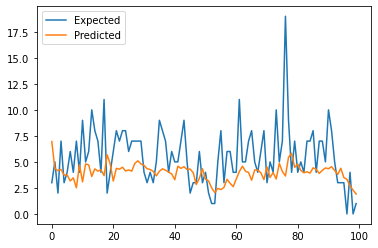

In [27]:
# walk-forward validation for XGBoost 1
mae, y, yhat = walk_forward_validation(data1, 100)
print('MAE: %.3f' % mae)

# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [28]:
# Store forecast result
xgboost1_df = pd.DataFrame(yhat)
xgboost1_df.columns = ['Predicted_Sales']
xgboost1_df = xgboost1_df.set_index(pd.date_range(start='8/30/2018', periods = 100))
xgboost1_df.index = pd.to_datetime(xgboost1_df.index)
xgboost1_df

,Predicted_Sales
2018-08-30,6.955610
2018-08-31,4.351778
2018-09-01,4.155508
2018-09-02,4.277337
2018-09-03,3.742450
...,...
2018-12-03,3.494585
2018-12-04,3.322509
2018-12-05,2.701157
2018-12-06,2.278192


### XGBoost with learning_rate = 0.05

In [29]:
# fit an xgboost model and make a one step forecasting
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate = 0.05)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

>expected=3.0, predicted=9.4
>expected=5.0, predicted=6.7
>expected=2.0, predicted=6.8
>expected=7.0, predicted=6.1
>expected=3.0, predicted=5.7
>expected=4.0, predicted=4.4
>expected=6.0, predicted=4.7
>expected=4.0, predicted=5.6
>expected=7.0, predicted=4.3
>expected=4.0, predicted=7.5
>expected=9.0, predicted=4.5
>expected=5.0, predicted=6.4
>expected=6.0, predicted=6.5
>expected=10.0, predicted=6.4
>expected=8.0, predicted=7.0
>expected=7.0, predicted=5.6
>expected=4.0, predicted=6.3
>expected=11.0, predicted=5.7
>expected=2.0, predicted=8.2
>expected=4.0, predicted=7.2
>expected=6.0, predicted=4.3
>expected=8.0, predicted=6.2
>expected=7.0, predicted=6.4
>expected=8.0, predicted=7.2
>expected=8.0, predicted=6.3
>expected=6.0, predicted=6.0
>expected=7.0, predicted=6.6
>expected=7.0, predicted=7.4
>expected=7.0, predicted=7.6
>expected=7.0, predicted=7.5
>expected=4.0, predicted=6.7
>expected=3.0, predicted=6.3
>expected=4.0, predicted=5.8
>expected=3.0, predicted=5.7
>expected=5.

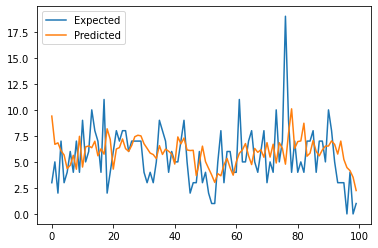

In [30]:
# walk-forward validation for XGBoost 2
mae, y, yhat = walk_forward_validation(data1, 100)
print('MAE: %.3f' % mae)

# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [31]:
# Store forecast result
xgboost2_df = pd.DataFrame(yhat)
xgboost2_df.columns = ['Predicted_Sales']
xgboost2_df = xgboost2_df.set_index(pd.date_range(start='8/30/2018', periods = 100))
xgboost2_df.index = pd.to_datetime(xgboost2_df.index)
xgboost2_df

,Predicted_Sales
2018-08-30,9.401933
2018-08-31,6.688394
2018-09-01,6.831027
2018-09-02,6.079857
2018-09-03,5.664455
...,...
2018-12-03,5.236747
2018-12-04,4.454895
2018-12-05,4.157978
2018-12-06,3.522766


# Results Comparison

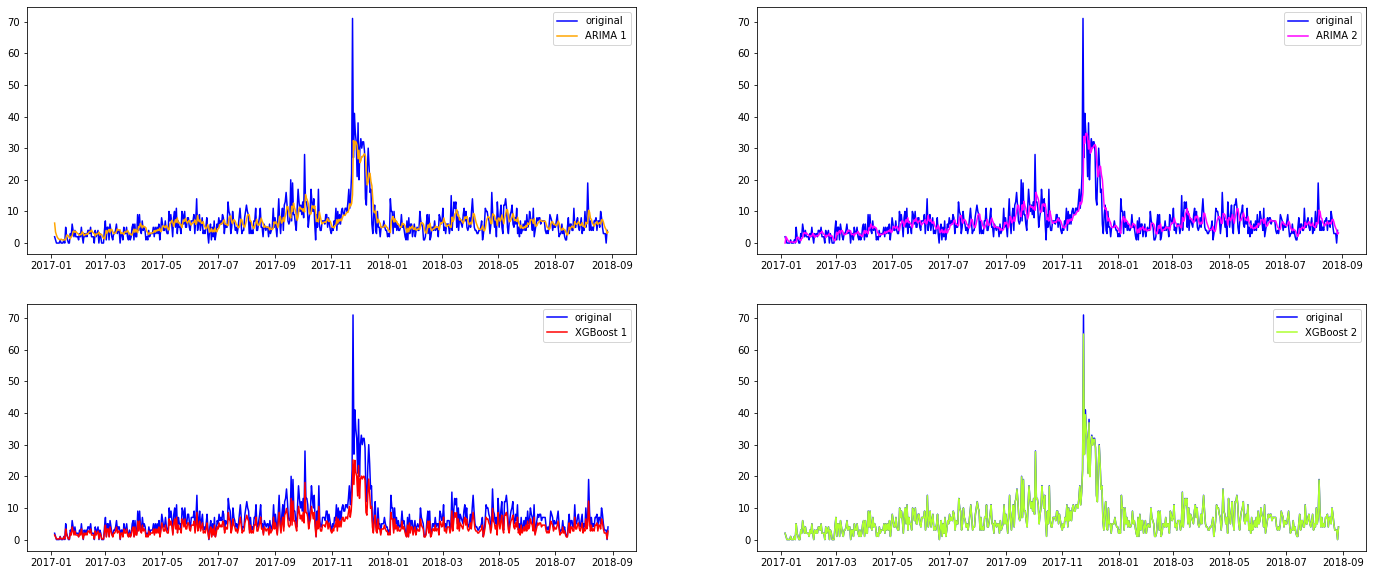

In [32]:
# Plot prediction results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,10))

# ARIMA 1
ax1.plot(df8.toys_sales[:600], label = 'original', color = 'blue')
ax1.plot(results.predict(0,600), label = 'ARIMA 1', color = 'orange')
ax1.legend()

# ARIMA 2
ax2.plot(df8.toys_sales[:600], label = 'original', color = 'blue')
ax2.plot(results1.predict(0,600), label = 'ARIMA 2', color = 'magenta')
ax2.legend()

# XGBoost 1
ax3.plot(df8.toys_sales[:600], label = 'original', color = 'blue')
ax3.plot(test1_df.prediction[:600], label = 'XGBoost 1', color = 'red')
ax3.legend()

# XGBoost 2
ax4.plot(df8.toys_sales[:600], label = 'original', color = 'blue')
ax4.plot(test2_df.predictions[:600], label = 'XGBoost 2', color = 'greenyellow')
ax4.legend()

<AxesSubplot:>

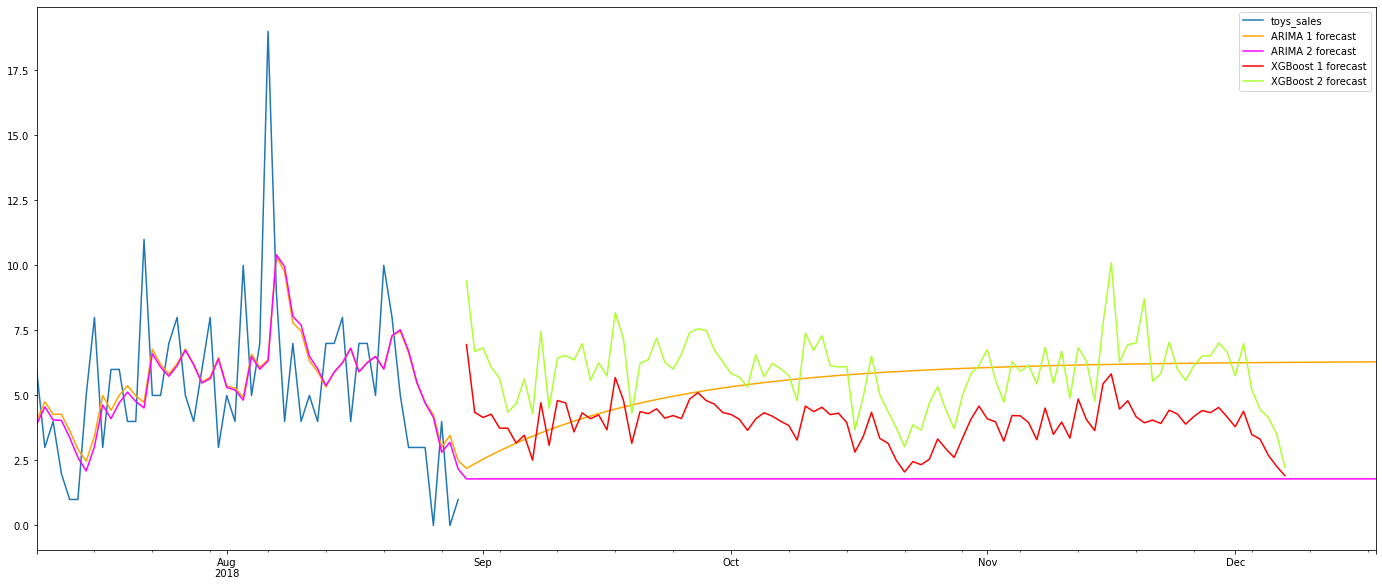

In [33]:
# Plot forecast result
forecast_plot = results.predict(start = 550,
                            end = len(data)+100,
                            typ = 'levels').rename('ARIMA 1 forecast')
forecast_plot1 = results1.predict(start = 550,
                            end = len(data)+100,
                            typ = 'levels').rename('ARIMA 2 forecast')

df8['toys_sales'][550:].plot(figsize=(24,10), legend = True)
forecast_plot.plot(legend=True, color = 'orange')
forecast_plot1.plot(legend=True, color = 'magenta')
xgboost1_df['Predicted_Sales'].plot(legend=True, label = 'XGBoost 1 forecast', color = 'red')
xgboost2_df['Predicted_Sales'].plot(legend=True, label = 'XGBoost 2 forecast', color = 'greenyellow')